In [1]:
# packages

# JAX
import jax.ops as jop
import jax.numpy as jnp
from jax import grad, vmap
from jax.config import config; 
config.update("jax_enable_x64", True)

# Numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt

We solve the following Burgers equation 
\begin{equation*}
\begin{aligned}
& u_t+\alpha u u_x-\nu u_{xx}=0, x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}
The parameter $\nu$ controls the shock.

In [2]:
# fix random seeds, for generating reference solution & sampled points
# random.seed(20)

# we will use x=(x1,x2) as (t,x)

alpha = 1 # control the nonlinearity
# nu = 0.03/onp.pi # control the diffusion, nu = 0.01/pi leads to strong shock
nu = 0.02

# boundary condition
def u(x1, x2):
    return -jnp.sin(jnp.pi*x2)*(x1==0) + 0*(x2==0)

# right hand side
def f(x1, x2):
    return 0


In [3]:
# obtain the ground truth solution via the Cole-Hopf transformation
# we use numerical integration to get the true solution

[Gauss_pts, weights] = onp.polynomial.hermite.hermgauss(80)

def u_true(x1, x2):
    temp = x2-jnp.sqrt(4*nu*x1)*Gauss_pts
    val1 = weights * jnp.sin(jnp.pi*temp) * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    val2 = weights * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    return -jnp.sum(val1)/jnp.sum(val2)



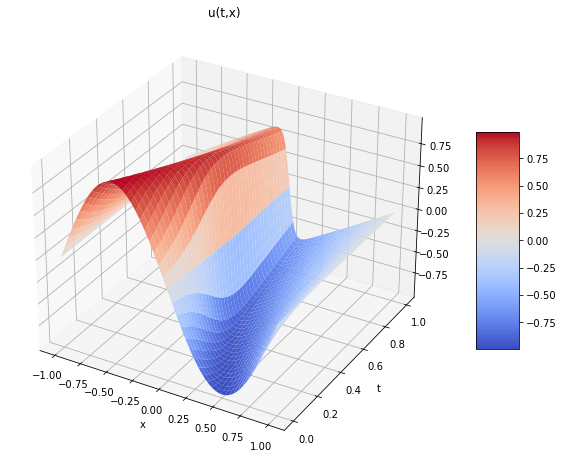

In [4]:
# plot the solution u(x,y), at the space-time domain or at a single time
    
def plot_u(num_pts1, num_pts2):
    xx = onp.linspace(0, 1, num_pts1)
    yy = onp.linspace(-1, 1, num_pts2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts2,num_pts1)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('u(t,x)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
def plot_u_time_t(t, num_pts):
    xx = t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(yy, ZZ_u)
    plt.xlabel('x')
    plt.title('u(t,x) at time %f' %t)
    plt.show()
    
# test
# plot the figure
plot_u(40,400)

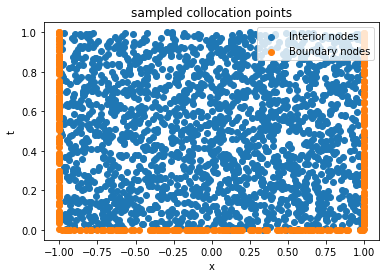

In [6]:
# sampled collocation points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0, 1.0, (N_domain, 2))
    X_domain[:,1] = 2*X_domain[:,1]-1
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[:int(N_boundary/3), 1] = random.uniform(-1.0, 1.0, int(N_boundary/3))
    # right face
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = 1
    # left face
    X_boundary[2*int(N_boundary/3):, 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[2*int(N_boundary/3):, 1] = -1
    
    return X_domain, X_boundary

N_domain_tot = 2000
N_boundary_tot = 399

X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.title('sampled collocation points')
plt.show()

Now, let us define kernels / covariance functions that are used to solve the PDEs

We use kernels for both time and space as:
$$k(x,y) = \exp(-\alpha_1^2(x_1-y_1)^2-\alpha_2^2(x_2-y_2)^2)$$

where:
$\alpha_1$: scale parameter in time

$\alpha_2$: scale parameter in space


In [7]:
# kernels and derivatives

def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    
    scale_t = sigma[0]
    scale_x = sigma[1]
    
    r = (scale_t*(x1-y1))**2+(scale_x*(x2-y2))**2

    return jnp.exp(-r)


def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),1)(x1, x2, y1, y2, sigma)
    return val

def D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,3)(x1, x2, y1, y2, sigma)
    return val

def DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),2)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(x1, x2, y1, y2, sigma)
    return val


Now, we will construct the Gram matrix, based on the observation $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$

We organize all the variables in the way: $[v_1,v_2,v_3,v_0,v_b]$, where $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively; and $v_b$ is the boundary value. 

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [8]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = jnp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1)))
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1))
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 0:N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, N_domain:2*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten())
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 3*N_domain:], jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    
    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, N_domain:2*N_domain], jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 2*N_domain:3*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    # calculate trace
    trace1 = jnp.trace(Theta[:N_domain, :N_domain])
    trace2 = jnp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = jnp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = jnp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    
    temp=jnp.concatenate((ratio[0]*jnp.ones((1,N_domain)), ratio[1]*jnp.ones((1,N_domain)), ratio[2]*jnp.ones((1,N_domain)), jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*jnp.diag(temp[0]) 
    L = jnp.linalg.cholesky(Theta)
    
    return L


In the above, we added trace-adaptive nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{\lambda}^{-1} [v_1,v_2,v_3,v_0,v_b]^T\\
  \text{s.t.}&\quad v_1+\alpha v_0v_2-\nu v_3=f, \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

In [9]:
# loss functions
def J(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]
    
    vv = jnp.append(nu*v3+rhs_f-alpha*v0*v2, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

# gradient of loss functions
grad_J = grad(J)

# Hessian in the Gaussian Newton method
def Hessian_GN(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    N_boundary = bdy_g.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]

    mtx = jnp.zeros((4*N_domain+N_boundary, 3*N_domain))
    mtx1 = jnp.concatenate((-alpha*jnp.diag(v2), -alpha*jnp.diag(v0), nu*jnp.eye(N_domain)), axis=1)
    mtx = jop.index_update(mtx, jop.index[0:N_domain, :], mtx1)
    mtx = jop.index_update(mtx, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[3*N_domain:4*N_domain, :N_domain], jnp.eye(N_domain))
    ss = jnp.linalg.solve(L, mtx)
    return 2*jnp.matmul(jnp.transpose(ss),ss)

# solve PDEs
def pde_solver(X_domain, X_boundary, nugget, max_iter, initial_sol, set_sigma, output_history = 0):
    N_domain = X_domain.shape[0]
    
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])  # rhs data
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1]) # boundary data
    
    # define cost function
    L = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)
    sol = initial_sol
    step_size = 1
    
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    for iter_step in range(max_iter):
        temp = jnp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp
        
        # iteration history
        if output_history == 1:
            J_now = J(sol,rhs_f,bdy_g,L)
            J_hist.append(J_now)
            print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)
    J_now = J(sol,rhs_f,bdy_g,L)
    return sol, J_hist, J_now, L




In [10]:
# ----- test pde solution

nugget=1e-10
max_iter=12
initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
set_sigma=jnp.array([3,20])
print('parameter sigma is set to be ', set_sigma)
sol, J_hist, J_final, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)



parameter sigma is set to be  [ 3 20]
iter =  0 Gauss-Newton step size = 1  J =  1737144346606.0952
iter =  1 Gauss-Newton step size = 1  J =  154176501371.51578
iter =  2 Gauss-Newton step size = 1  J =  254238901040.708
iter =  3 Gauss-Newton step size = 1  J =  10513779043.810562
iter =  4 Gauss-Newton step size = 1  J =  1997782.8203579988
iter =  5 Gauss-Newton step size = 1  J =  1630.4645866399105
iter =  6 Gauss-Newton step size = 1  J =  1630.3359471376295
iter =  7 Gauss-Newton step size = 1  J =  1630.3359469916224
iter =  8 Gauss-Newton step size = 1  J =  1630.3359469876043
iter =  9 Gauss-Newton step size = 1  J =  1630.3359469893046
iter =  10 Gauss-Newton step size = 1  J =  1630.3359469926786
iter =  11 Gauss-Newton step size = 1  J =  1630.3359469906895


In [11]:
# extend solution to the whole domain: functions

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    N_test = X_test.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_left coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # left v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # left v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1, x2, y1, y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:,3*N_domain:4*N_domain+N_boundary] = onp.reshape(val, (N_test, N_domain+N_boundary))

    return inpTheta


def extend_solution(X_test, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain_tot, X_boundary_tot)
    
    aux = jnp.linalg.solve(jnp.transpose(L),jnp.linalg.solve(L,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u


def sol_time_t(t, num_pts, sol, L):
    xx=t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1) 

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
    v0 = sol[:N_domain_tot]
    v2 = sol[N_domain_tot:2*N_domain_tot]
    v3 = sol[2*N_domain_tot:]
    vv = jnp.concatenate((nu*v3+rhs_f-alpha*v0*v2, v2, v3, v0, bdy_g), axis=0)
    
    extended_u = extend_solution(X_test, L, vv)
    u_truth=vmap(u_true)(XXv, YYv)
    u_truth=u_truth.flatten()
    
    # L2err
    L2err = onp.sqrt(onp.sum((extended_u-u_truth)**2)/(num_pts))
    # Maxerr
    Maxerr = onp.max(abs(extended_u-u_truth))
    
    return yy, extended_u, u_truth, L2err, Maxerr

def sol_time_space(num_pts_time, num_pts_space, sol, L):
    xx= onp.linspace(0, 1, num_pts_time)
    yy = onp.linspace(-1, 1, num_pts_space)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1) 

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
    v0 = sol[:N_domain_tot]
    v2 = sol[N_domain_tot:2*N_domain_tot]
    v3 = sol[2*N_domain_tot:]
    vv = jnp.concatenate((nu*v3+rhs_f-alpha*v0*v2, v2, v3, v0, bdy_g), axis=0)
    
    extended_u = extend_solution(X_test, L, vv)
    extended_u = extended_u.reshape(num_pts_space, num_pts_time)
    
    u_truth = onp.vectorize(u_true)(XXv, YYv)
    u_truth = u_truth.reshape(num_pts_space, num_pts_time)
    
    # L2err
    L2err = onp.linalg.norm(extended_u-u_truth,'fro')/(onp.sqrt(num_pts_space*num_pts_time))
    
    # Maxerr
    Maxerr = onp.max(abs(extended_u-u_truth))
    
    return XX, YY, extended_u, u_truth, L2err, Maxerr




In [12]:
# extend solution: data calculation

num_pts_time = 100
num_pts_space = 400
XX, YY, extended_u, u_truth, space_time_L2err, space_time_Maxerr = sol_time_space(num_pts_time, num_pts_space, sol, L)

t = 0.2
yy, extended_u_t1, u_truth_t1, L2err_t1, Maxerr_t1 = sol_time_t(t, num_pts_space, sol, L)

t = 0.5
yy, extended_u_t2, u_truth_t2, L2err_t2, Maxerr_t2 = sol_time_t(t, num_pts_space, sol, L)

t = 0.8
yy, extended_u_t3, u_truth_t3, L2err_t3, Maxerr_t3 = sol_time_t(t, num_pts_space, sol, L)



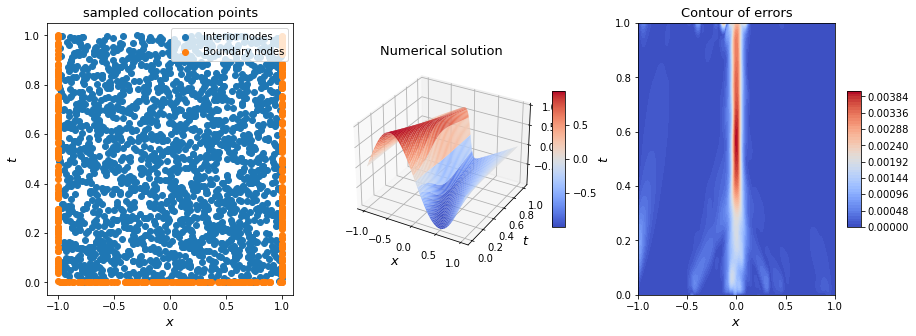

sigma = [ 3 20] , nugget = 1e-10 , # pts:  2399 
 space-time L2 error:  0.0005787693734057316 , max err:  0.003968982420448644


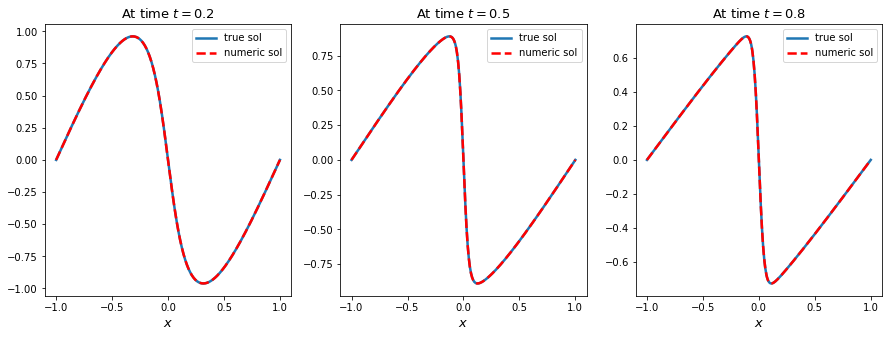

t=0.2, L2 error:  0.000449466665597656 , max err:  0.0018422719296096388
t=0.5, L2 error:  0.0006782161833037479 , max err:  0.0038565263754732834
t=0.8, L2 error:  0.0006278441038178704 , max err:  0.0034373885963013273


In [13]:
# plot figures
here_fontsize=13

# --------------space time plot---------------------
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points', fontsize=here_fontsize)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 

# plot the numerical solution
ax = fig.add_subplot(132, projection='3d')
u_sol_surf=ax.plot_surface(YY, XX, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize) 
plt.title('Numerical solution', fontsize=here_fontsize)
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 10)

# contourf
ax = fig.add_subplot(133)
u_contourf=ax.contourf(YY, XX, abs(extended_u-u_truth), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x$', fontsize=here_fontsize)
plt.ylabel('$t$', fontsize=here_fontsize)
plt.title('Contour of errors', fontsize=here_fontsize)
fig.colorbar(u_contourf, shrink= 0.5, aspect = 10)

plt.show()
fig.tight_layout()

# fig.savefig('Burgers_pts1500_sol_contour_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

print('sigma =', set_sigma, ', nugget =', nugget, ', # pts: ', N_domain_tot+N_boundary_tot, '\n space-time L2 error: ', space_time_L2err, ', max err: ', space_time_Maxerr)

# ---------------time slice plot--------------------
fig = plt.figure(figsize=(15,5))

# plot the numerical solution
ax = fig.add_subplot(131)
ax.plot(yy, u_truth_t1, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t1, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.2$', fontsize=here_fontsize)

ax = fig.add_subplot(132)
ax.plot(yy, u_truth_t2, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t2, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.5$', fontsize=here_fontsize)

ax = fig.add_subplot(133)
ax.plot(yy, u_truth_t3, linewidth=2.5, label='true sol')
ax.plot(yy, extended_u_t3, linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$', fontsize=here_fontsize)
ax.legend()
plt.title('At time $t = 0.8$',fontsize=here_fontsize)

plt.show()
fig.tight_layout()
# fig.savefig('Burgers_pts1500_time_sol_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)

print('t=0.2, L2 error: ', L2err_t1 , ', max err: ', Maxerr_t1)
print('t=0.5, L2 error: ', L2err_t2 , ', max err: ', Maxerr_t2)
print('t=0.8, L2 error: ', L2err_t3 , ', max err: ', Maxerr_t3)



In [14]:
# store data
onp.savez('Burgers_demon_Float64.npz', XX=XX, YY=YY, extended_u=extended_u, u_truth=u_truth, X_domain_tot=X_domain_tot, X_boundary_tot=X_boundary_tot, max_iter=max_iter, J_hist=J_hist, u_truth_t1=u_truth_t1, extended_u_t1=extended_u_t1, u_truth_t2=u_truth_t2, extended_u_t2=extended_u_t2, u_truth_t3=u_truth_t3, extended_u_t3=extended_u_t3, yy = yy)

Documentation of numerical results

sigma = [ 3 20] , nugget = 1e-05 , # pts:  750 
 space-time L2 error:  0.10160466581227426 , max err:  0.47363561775444574
t=0.2, L2 error:  0.061588511427789 , max err:  0.3021788211497273
t=0.5, L2 error:  0.1295885184998618 , max err:  0.39139051175018535
t=0.8, L2 error:  0.10954162728536723 , max err:  0.271432475695054

sigma = [ 3 20] , nugget = 1e-05 , # pts:  900 
 space-time L2 error:  0.015630091244862695 , max err:  0.20751530013115593
 t=0.2, L2 error:  0.01007431431243863 , max err:  0.027753629990494022
t=0.5, L2 error:  0.025562556441388464 , max err:  0.18403102505542518
t=0.8, L2 error:  0.011662264319003182 , max err:  0.043816333731768464

sigma = [ 3 20] , nugget = 1e-05 , # pts:  1500 
space-time L2 error:  0.0030783594929309336 , max err:  0.01990738612649845
t=0.2, L2 error:  0.003195345 , max err:  0.0087096095
t=0.5, L2 error:  0.0023129175 , max err:  0.0074320138
t=0.8, L2 error:  0.0035708416 , max err:  0.01660771

sigma = [ 3 20] , nugget = 1e-05 , # pts:  3000 
 space-time L2 error:  0.00048565447364017436 , max err:  0.003465092851008933
t=0.2, L2 error:  0.00063299225 , max err:  0.0018203259
t=0.5, L2 error:  0.0005092034 , max err:  0.0026029497
t=0.8, L2 error:  0.00019202505 , max err:  0.00072687864

In [13]:
# convergence curve for multiple random instances

arr_N_pts = 2**onp.array([3,4,5,6])-2
arr_total_pts = (arr_N_pts+2)**2
arr_num = onp.shape(arr_N_pts)[0]
arr_num_rdm = 10
arr_maxerr = onp.zeros((arr_num_rdm, arr_num))
arr_L2err = onp.zeros((arr_num_rdm, arr_num))


for j in range(arr_num_rdm):
    for i in range(arr_num):
        N_pts = arr_N_pts[i]
        N_domain_tot = N_pts**2+N_pts+1
        N_boundary_tot = 3*(N_pts+1)
        X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

        nugget=1e-12
        max_iter=12
        initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
        set_sigma=jnp.array([3,20])
        step_size = 1
        
        sol, J_hist, J_final, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)

        num_pts_time = 100
        num_pts_space = 200
        XX, YY, extended_u, u_truth, space_time_L2err, space_time_Maxerr = sol_time_space(num_pts_time, num_pts_space, sol, L)

        arr_L2err[j,i] = space_time_L2err
        arr_maxerr[j,i] = space_time_Maxerr
        print('sigma =', set_sigma, ', nugget =', nugget, ', # pts: ', N_domain_tot+N_boundary_tot, 'L2 error:', space_time_L2err, 'max error:', space_time_Maxerr)
    

iter =  0 Gauss-Newton step size = 1  J =  635.5852487290258
iter =  1 Gauss-Newton step size = 1  J =  11.6871310271802
iter =  2 Gauss-Newton step size = 1  J =  2.4821702589870536
iter =  3 Gauss-Newton step size = 1  J =  2.4820160889874328
iter =  4 Gauss-Newton step size = 1  J =  2.4820155873724135
iter =  5 Gauss-Newton step size = 1  J =  2.4820155700743136
iter =  6 Gauss-Newton step size = 1  J =  2.4820155694738877
iter =  7 Gauss-Newton step size = 1  J =  2.4820155694530235
iter =  8 Gauss-Newton step size = 1  J =  2.4820155694523027
iter =  9 Gauss-Newton step size = 1  J =  2.482015569452275
iter =  10 Gauss-Newton step size = 1  J =  2.4820155694522765
iter =  11 Gauss-Newton step size = 1  J =  2.4820155694522774
sigma = [ 3 20] , nugget = 1e-12 , # pts:  64 L2 error: 0.527045927555698 max error: 1.016443543918685
iter =  0 Gauss-Newton step size = 1  J =  5806897205.758167
iter =  1 Gauss-Newton step size = 1  J =  871733850.1769114
iter =  2 Gauss-Newton step size 

KeyboardInterrupt: 

In [16]:
# convergence curve for multiple random instances

arr_N_domain_tot = [960,1440,1920,2400]
arr_N_boundary_tot = [240,360,480,600]
arr_num = onp.shape(arr_N_domain_tot)[0]
arr_num_rdm = 10
arr_maxerr = onp.zeros((arr_num_rdm, arr_num))
arr_L2err = onp.zeros((arr_num_rdm, arr_num))


for j in range(arr_num_rdm):
    for i in range(arr_num):
        N_domain_tot = arr_N_domain_tot[i]
        N_boundary_tot = arr_N_boundary_tot[i]
        X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

        nugget=1e-5
        max_iter=12

        initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
        set_sigma=jnp.array([3,20])
        step_size = 1
        
        sol, J_hist, J_final, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)

        num_pts_time = 100
        num_pts_space = 200
        XX, YY, extended_u, u_truth, space_time_L2err, space_time_Maxerr = sol_time_space(num_pts_time, num_pts_space, sol, L)

        arr_L2err[j,i] = space_time_L2err
        arr_maxerr[j,i] = space_time_Maxerr
        print('sigma =', set_sigma, ', nugget =', nugget, ', # pts: ', N_domain_tot+N_boundary_tot, 'L2 error:', space_time_L2err, 'max error:', space_time_Maxerr)
    

iter =  0 Gauss-Newton step size = 1  J =  9205850.789901884
iter =  1 Gauss-Newton step size = 1  J =  1901838.3720729128
iter =  2 Gauss-Newton step size = 1  J =  575024.6976002877
iter =  3 Gauss-Newton step size = 1  J =  2835.700876140898
iter =  4 Gauss-Newton step size = 1  J =  25.505492377435807
iter =  5 Gauss-Newton step size = 1  J =  25.260046659196078
iter =  6 Gauss-Newton step size = 1  J =  25.260044856865733
iter =  7 Gauss-Newton step size = 1  J =  25.260044854740357
iter =  8 Gauss-Newton step size = 1  J =  25.260044854725447
iter =  9 Gauss-Newton step size = 1  J =  25.260044854725034
iter =  10 Gauss-Newton step size = 1  J =  25.260044854725137
iter =  11 Gauss-Newton step size = 1  J =  25.26004485472435
sigma = [ 3 20] , nugget = 1e-05 , # pts:  1200 L2 error: 0.00378684294170189 max error: 0.03238384721117027
iter =  0 Gauss-Newton step size = 1  J =  8341662.5600666385
iter =  1 Gauss-Newton step size = 1  J =  2938265.612873968
iter =  2 Gauss-Newton ste

KeyboardInterrupt: 

In [34]:
print(arr_maxerr)
print(arr_L2err)

average_maxerr = onp.nanmean(arr_maxerr, axis=0)
std_maxerr = onp.sqrt(onp.nanmean((arr_maxerr-average_maxerr)**2, axis = 0))

average_L2err = onp.nanmean(arr_L2err, axis=0)
std_L2err = onp.sqrt(onp.nanmean((arr_L2err-average_L2err)**2, axis = 0))

print('average_maxerr is', average_maxerr, 'std is', std_maxerr)
print('average_L2err is', average_L2err, 'std is', std_L2err)

arr_maxerr2 = arr_maxerr[[0,1,2,3,4,6,8,9],:]
average_maxerr2 = onp.nanmean(arr_maxerr2, axis=0)
std_maxerr2 = onp.sqrt(onp.nanmean((arr_maxerr2-average_maxerr2)**2, axis = 0))

arr_L2err2 = arr_L2err[[0,1,2,3,4,6,8,9],:]
average_L2err2 = onp.nanmean(arr_L2err2, axis=0)
std_L2err2 = onp.sqrt(onp.nanmean((arr_L2err2-average_L2err2)**2, axis = 0))

print('average_maxerr is', average_maxerr2, 'std is', std_maxerr2)
print('average_L2err is', average_L2err2, 'std is', std_L2err2)



[[0.03749069 0.01277945 0.01643835 0.00489395]
 [0.10344059 0.01390609 0.00838344 0.00515755]
 [0.02966729 0.00798049 0.00515118 0.00403498]
 [0.10641204 0.02705754 0.00854397 0.00638189]
 [0.05972612 0.01987155 0.00916798 0.00352502]
 [0.48573518 0.00791325 0.00551661 0.00274881]
 [0.11026351 0.02329245 0.00733914 0.00428981]
 [1.34584662 0.01656926 0.01467041 0.0033374 ]
 [0.05409813 0.01185073 0.01007001 0.00892122]
 [0.07297209 0.01048727 0.01293065 0.0050945 ]]
[[0.00699374 0.0015204  0.00242454 0.00076245]
 [0.00727858 0.00156664 0.00128633 0.00076805]
 [0.00470099 0.00162551 0.00073909 0.0006252 ]
 [0.00839763 0.00194537 0.00121574 0.00094825]
 [0.00740377 0.00304084 0.00167371 0.00044219]
 [0.04564175 0.00107457 0.0007833  0.00048469]
 [0.01606928 0.00324581 0.00077017 0.00075502]
 [0.20162833 0.00267617 0.00179224 0.00065771]
 [0.00626716 0.00123617 0.00146084 0.00144585]
 [0.01188434 0.00179935 0.001898   0.0006655 ]]
average_maxerr is [0.24056523 0.01517081 0.00982117 0.0048

[[0.03749069 0.01277945 0.01643835 0.00489395]
 [0.10344059 0.01390609 0.00838344 0.00515755]
 [0.02966729 0.00798049 0.00515118 0.00403498]
 [0.10641204 0.02705754 0.00854397 0.00638189]
 [0.05972612 0.01987155 0.00916798 0.00352502]
 [0.48573518 0.00791325 0.00551661 0.00274881]
 [0.11026351 0.02329245 0.00733914 0.00428981]
 [1.34584662 0.01656926 0.01467041 0.0033374 ]
 [0.05409813 0.01185073 0.01007001 0.00892122]
 [0.07297209 0.01048727 0.01293065 0.0050945 ]]
[[0.00699374 0.0015204  0.00242454 0.00076245]
 [0.00727858 0.00156664 0.00128633 0.00076805]
 [0.00470099 0.00162551 0.00073909 0.0006252 ]
 [0.00839763 0.00194537 0.00121574 0.00094825]
 [0.00740377 0.00304084 0.00167371 0.00044219]
 [0.04564175 0.00107457 0.0007833  0.00048469]
 [0.01606928 0.00324581 0.00077017 0.00075502]
 [0.20162833 0.00267617 0.00179224 0.00065771]
 [0.00626716 0.00123617 0.00146084 0.00144585]
 [0.01188434 0.00179935 0.001898   0.0006655 ]]
average_maxerr is [0.24056523 0.01517081 0.00982117 0.00483851] std is [0.38946264 0.00613154 0.0035729  0.00168858]
average_L2err is [0.03162656 0.00197308 0.00140439 0.00075549] std is [0.05781248 0.00071599 0.00052826 0.00026835]
average_maxerr is [0.07175881 0.0159032  0.00975309 0.00528737] std is [0.02977279 0.00629522 0.00327061 0.00159221]
average_L2err is [0.00862444 0.00199751 0.00143355 0.00080156] std is [0.00340982 0.00069102 0.00053005 0.00027844]